In [14]:
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt

In [7]:
# načtení dat
cizinci_df = pd.read_csv('cizinci_data.csv', sep=',', encoding='utf-8')
hdp_df = pd.read_csv('gdp_data.csv', sep=',', encoding='utf-8')
# sloučení dat na základě country
merged_df = cizinci_df.merge(hdp_df, on='country', how='left')
# kontrola
missing = merged_df[merged_df['GDP'].isnull()]
print("Záznamy s chybějícím HDP:", len(missing))
# ukázka dokumentu pro mongodb
print(merged_df.head(1).to_dict(orient='records'))

Záznamy s chybějícím HDP: 689
[{'country': 'DZA', 'gender': 'muž', 'age': '<0; 5)', 'year_x': 2023, 'year_y': 2023.0, 'GDP': '5\xa0499\xa0777'}]


In [8]:
print(merged_df)

      country gender       age  year_x  year_y         GDP
0         DZA    muž    <0; 5)    2023  2023.0   5 499 777
1         AFG    muž  <35; 40)    2023  2023.0     382 746
2         AUT    muž  <30; 35)    2023  2023.0  11 364 528
3         BEL    muž    <0; 5)    2023  2023.0  14 320 625
4         BEL    muž  <60; 65)    2023  2023.0  14 320 625
...       ...    ...       ...     ...     ...         ...
60337     KNA   žena  <10; 15)    2023  2023.0      23 443
60338     GUY   žena  <20; 25)    2023  2023.0     381 113
60339     QAT   žena  <40; 45)    2023  2023.0   4 730 792
60340     SHN    muž  <20; 25)    2023     NaN         NaN
60341     TLS    muž  <20; 25)    2023  2023.0      46 195

[60342 rows x 6 columns]


In [10]:
# připojení k MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['cizinci_db']
collection = db['cizinci_hdp']
# vložení dat do MongoDB
records = merged_df.to_dict(orient='records')
collection.insert_many(records)

InsertManyResult([ObjectId('682e1647e7364820c64141d2'), ObjectId('682e1647e7364820c64141d3'), ObjectId('682e1647e7364820c64141d4'), ObjectId('682e1647e7364820c64141d5'), ObjectId('682e1647e7364820c64141d6'), ObjectId('682e1647e7364820c64141d7'), ObjectId('682e1647e7364820c64141d8'), ObjectId('682e1647e7364820c64141d9'), ObjectId('682e1647e7364820c64141da'), ObjectId('682e1647e7364820c64141db'), ObjectId('682e1647e7364820c64141dc'), ObjectId('682e1647e7364820c64141dd'), ObjectId('682e1647e7364820c64141de'), ObjectId('682e1647e7364820c64141df'), ObjectId('682e1647e7364820c64141e0'), ObjectId('682e1647e7364820c64141e1'), ObjectId('682e1647e7364820c64141e2'), ObjectId('682e1647e7364820c64141e3'), ObjectId('682e1647e7364820c64141e4'), ObjectId('682e1647e7364820c64141e5'), ObjectId('682e1647e7364820c64141e6'), ObjectId('682e1647e7364820c64141e7'), ObjectId('682e1647e7364820c64141e8'), ObjectId('682e1647e7364820c64141e9'), ObjectId('682e1647e7364820c64141ea'), ObjectId('682e1647e7364820c64141

# Vizualizace

In [18]:
# pomocná funkce pro čištění a převod GDP na int
def parse_gdp(gdp_str):
    # pokud není řetězec, např. float nan, vrať 0
    if not isinstance(gdp_str, str):
        return 0
    # vyber jen číslice
    digits = ''.join(ch for ch in gdp_str if ch.isdigit())
    return int(digits) if digits else 0

def gdp_category(gdp):
    if gdp < 10000:
        return 'low'
    elif gdp < 30000:
        return 'medium'
    else:
        return 'high'

# aktualizace dokumentů s číselným GDP i kategorií
for doc in collection.find():
    raw = doc.get('GDP', '')
    num = parse_gdp(raw)
    category = gdp_category(num)
    collection.update_one(
        {'_id': doc['_id']},
        {'$set': {'gdp_category': category, 'gdp_numeric': num}}
    )

In [19]:
pipeline = [
    {"$group": {"_id": "$gdp_category", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}}
]

results = list(collection.aggregate(pipeline))
for result in results:
    print(result)


{'_id': 'high', 'count': 59560}
{'_id': 'low', 'count': 691}
{'_id': 'medium', 'count': 91}


In [20]:
pipeline = [
    {"$group": {"_id": "$country", "total": {"$sum": 1}}},
    {"$sort": {"total": -1}},
    {"$limit": 10}
]

top_countries = list(collection.aggregate(pipeline))
for country in top_countries:
    print(country)


{'_id': 'UKR', 'total': 2798}
{'_id': 'SVK', 'total': 2739}
{'_id': 'VNM', 'total': 2510}
{'_id': 'RUS', 'total': 2055}
{'_id': 'POL', 'total': 2040}
{'_id': 'ROU', 'total': 1918}
{'_id': 'BGR', 'total': 1912}
{'_id': 'DEU', 'total': 1762}
{'_id': 'HUN', 'total': 1762}
{'_id': 'MDA', 'total': 1596}


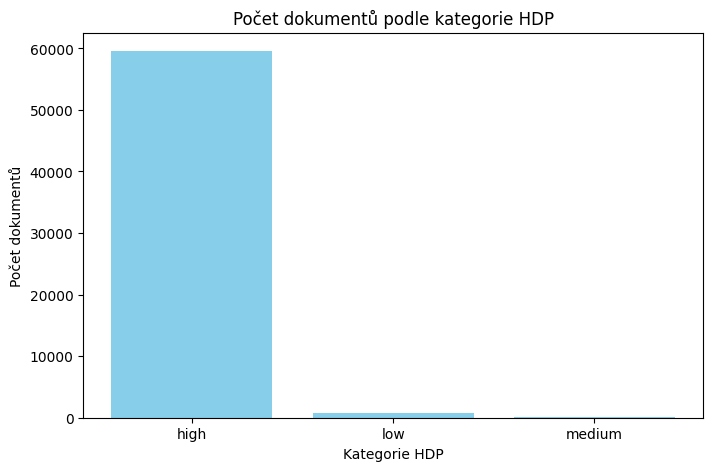

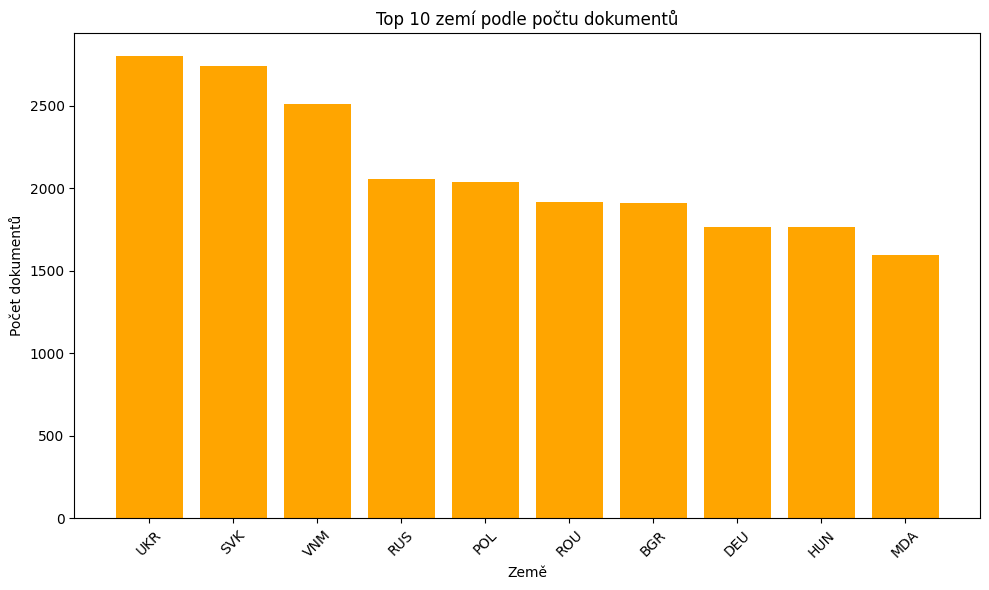

In [21]:
# Vizualizace počtu dokumentů podle kategorie HDP
pipeline = [
    {"$group": {"_id": "$gdp_category", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}}
]
gdp_counts = list(collection.aggregate(pipeline))
categories = [item['_id'] for item in gdp_counts]
counts = [item['count'] for item in gdp_counts]

plt.figure(figsize=(8,5))
plt.bar(categories, counts, color='skyblue')
plt.title("Počet dokumentů podle kategorie HDP")
plt.xlabel("Kategorie HDP")
plt.ylabel("Počet dokumentů")
plt.show()

# Vizualizace top 10 zemí podle počtu dokumentů
countries = [item['_id'] for item in top_countries]
totals = [item['total'] for item in top_countries]

plt.figure(figsize=(10,6))
plt.bar(countries, totals, color='orange')
plt.xticks(rotation=45)
plt.title("Top 10 zemí podle počtu dokumentů")
plt.xlabel("Země")
plt.ylabel("Počet dokumentů")
plt.tight_layout()
plt.show()